In [349]:
import numpy as np
import pandas as pd
import os
from random import shuffle
import matplotlib.pyplot as plt
from tqdm import tqdm #to be able to look at process of downloading
import cv2
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix,plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.ensemble import BaggingClassifier

In [313]:
#path = 'C:/אריאל נושאי לימוד/סמסטר ב/הדמיית נתונים/cats vs dogs/train'
path = 'C:/train'
pics = os.listdir(path)
IMG_SIZE = 40

In [314]:
len(pics)

25000

In [315]:
def count_pics(pics):
    dog_cnt = 0
    cat_cnt = 0

    for pic in pics:
        if pic[0] == 'c':
            cat_cnt +=1
        else:
            dog_cnt +=1

    print("dog pictures: ", dog_cnt)
    print("cat pictures: ", cat_cnt)
count_pics(pics)

dog pictures:  12500
cat pictures:  12500


In [316]:
def label_image(img):
    label = img.split('.')[0]
    if label == 'cat':return 1
    elif label == 'dog':return 0

In [317]:
train_data = []
labels = []
for img in tqdm(os.listdir(path)):
    label = label_image(img)
    pic_path = os.path.join(path, img)
    img = cv2.imread(pic_path,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    train_data.append(pd.Series(img.flatten()))
    labels.append(label)
        
        
        

100%|██████████| 25000/25000 [00:40<00:00, 610.78it/s]


In [318]:
df = pd.DataFrame(train_data)

In [319]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4790,4791,4792,4793,4794,4795,4796,4797,4798,4799
0,94,171,210,100,178,221,108,186,229,115,...,4,1,3,3,1,3,3,1,3,3
1,41,41,37,52,50,47,50,51,42,48,...,72,56,69,85,50,54,72,31,36,50
2,54,47,39,64,56,47,67,59,51,68,...,161,108,145,155,0,173,176,9,190,192
3,217,222,221,223,226,225,237,237,237,221,...,209,202,204,204,221,222,219,207,212,215
4,68,104,132,39,77,104,73,113,140,106,...,97,54,77,92,68,97,109,62,88,99


In [320]:
label_df = pd.DataFrame(labels, columns = ['label'])

In [321]:
label_df.head()

,label
0,1
1,1
2,1
3,1
4,1


In [322]:
df = pd.concat([df,label_df],axis=1)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4791,4792,4793,4794,4795,4796,4797,4798,4799,label
0,94,171,210,100,178,221,108,186,229,115,...,1,3,3,1,3,3,1,3,3,1
1,41,41,37,52,50,47,50,51,42,48,...,56,69,85,50,54,72,31,36,50,1
2,54,47,39,64,56,47,67,59,51,68,...,108,145,155,0,173,176,9,190,192,1
3,217,222,221,223,226,225,237,237,237,221,...,202,204,204,221,222,219,207,212,215,1
4,68,104,132,39,77,104,73,113,140,106,...,54,77,92,68,97,109,62,88,99,1


In [323]:
x = df.drop('label',axis=1)
y = df['label']

In [324]:
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = 0.15,random_state = 42)

## PCA

In [325]:
pca = PCA(n_components = 0.9)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.fit_transform(x_test)

286


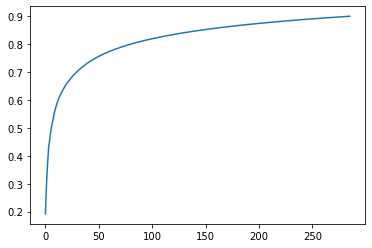

In [326]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
print(pca.n_components_)

In [327]:
scaling_pipeline = Pipeline(
[
    ('std_scaler', StandardScaler()),
    ('PCA',PCA(n_components = 0.9))
])

x_train = scaling_pipeline.fit_transform(x_train)
x_test = scaling_pipeline.transform(x_test)

## Random Forest

In [328]:
rf = RandomForestClassifier(n_estimators = 200,random_state = 2, n_jobs = -1)
rf.fit(x_train, y_train)

RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=2)

In [329]:
rf.score(x_test,y_test)

0.6341333333333333

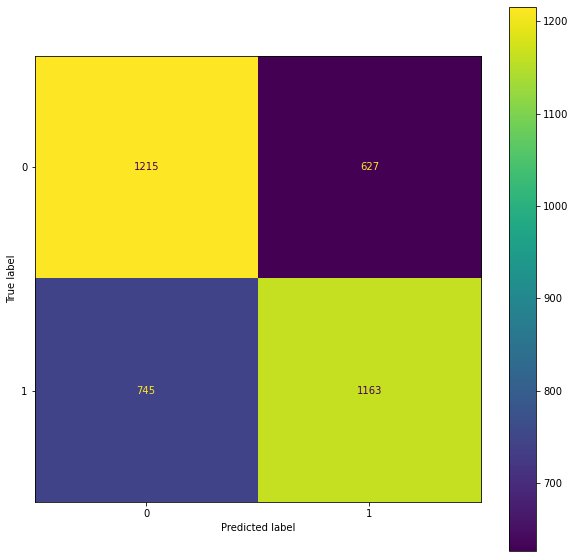

In [344]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(10,10)
plot_confusion_matrix(rf,x_test,y_test,ax=ax)

### Tuning

In [330]:
forest_params = {
    'n_estimators':[100,200,300],
    'max_depth':[20,40,60],
    'max_features':['auto','sqrt','log']
}
rnd_grid_search = RandomizedSearchCV(RandomForestClassifier(),
                                    forest_params,
                                     n_jobs = -1,
                                     n_iter = 3,
                                     scoring = 'accuracy',
                                     return_train_score = True
                                    )

rnd_grid_search.fit(x_train,y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=3, n_jobs=-1,
                   param_distributions={'max_depth': [20, 40, 60],
                                        'max_features': ['auto', 'sqrt', 'log'],
                                        'n_estimators': [100, 200, 300]},
                   return_train_score=True, scoring='accuracy')

In [331]:
rnd_grid_search.best_estimator_

RandomForestClassifier(max_depth=60, max_features='sqrt')

In [332]:
rnd_grid_search.best_score_

0.6201882352941176

## KNN

In [336]:
scores = []
for i in range(10,31):
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs = -1)
    knn.fit(x_train,y_train)
    scores.append(knn.score(x_test,y_test))
    print("n=",i, " accuracy: ", knn.score(x_test,y_test))

n= 10  accuracy:  0.6016
n= 11  accuracy:  0.6085333333333334
n= 12  accuracy:  0.6072
n= 13  accuracy:  0.6122666666666666
n= 14  accuracy:  0.6112
n= 15  accuracy:  0.6128
n= 16  accuracy:  0.6104
n= 17  accuracy:  0.6181333333333333
n= 18  accuracy:  0.6109333333333333
n= 19  accuracy:  0.6170666666666667
n= 20  accuracy:  0.6133333333333333
n= 21  accuracy:  0.6152
n= 22  accuracy:  0.6133333333333333
n= 23  accuracy:  0.6173333333333333
n= 24  accuracy:  0.6114666666666667
n= 25  accuracy:  0.6170666666666667
n= 26  accuracy:  0.6152
n= 27  accuracy:  0.6208
n= 28  accuracy:  0.6168
n= 29  accuracy:  0.6184
n= 30  accuracy:  0.6141333333333333


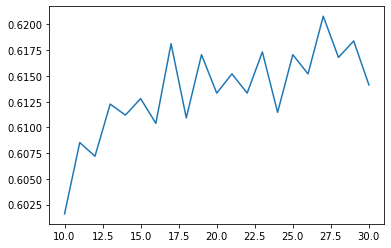

In [338]:
plt.plot(list(range(10,31)),scores)

In [339]:
top_knn = KNeighborsClassifier(n_neighbors=27, n_jobs = -1)
top_knn.fit(x_train,y_train)
knn.score(x_test,y_test)

0.6141333333333333

## XGBOOST

In [340]:
xgb = XGBClassifier(n_jobs = -1)
xgb.fit(x_train, y_train)

xgb.score(x_test,y_test)

C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:49:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.6512

In [346]:
print(classification_report(xgb.predict(x_test),y_test))

              precision    recall  f1-score   support

           0       0.64      0.65      0.64      1808
           1       0.67      0.65      0.66      1942

    accuracy                           0.65      3750
   macro avg       0.65      0.65      0.65      3750
weighted avg       0.65      0.65      0.65      3750



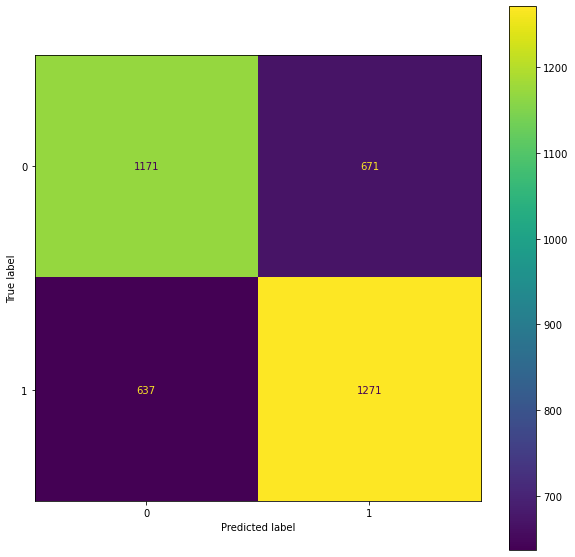

In [345]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(10,10)
plot_confusion_matrix(xgb,x_test,y_test,ax=ax)

### Tuning

In [341]:
xgb_params = {
    'n_estimators': [100,200],
    'max_depth': [3,6,9],
    'learning_rate': [0.01,0.1]
    
}
xgb_rnd_grid_search = RandomizedSearchCV(XGBClassifier(),
                                        xgb_params,
                                        n_jobs = -1,
                                         n_iter = 1,
                                        scoring = 'accuracy',
                                        return_train_score = True)

xgb_rnd_grid_search.fit(x_train,y_train)

C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:52:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                           reg_lamb

In [342]:
xgb_rnd_grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [343]:
xgb_rnd_grid_search.best_score_

0.5890823529411765

## Voting

In [347]:
voting_clf = VotingClassifier(
    estimators=[('knn',top_knn),('rf',rf),('xgb',xgb)],
    voting = 'soft',
    weights=[1,2,4],
    n_jobs=-1
)
voting_clf.fit(x_train,y_train)

VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(n_jobs=-1, n_neighbors=27)),
                             ('rf',
                              RandomForestClassifier(n_estimators=200,
                                                     n_jobs=-1,
                                                     random_state=2)),
                             ('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                                            max_delta_step=0, max_depth=6,
                           

In [348]:
voting_clf.score(x_test,y_test)

0.6621333333333334

## bagging on voting classifier

### need to create new voting classifier because knn doesnt support sample weights

In [352]:
voting_clf_for_bagging = VotingClassifier(
    estimators=[('rf',rf),('xgb',xgb)],
    voting = 'soft',
    weights=[1,2],
    n_jobs=-1
)
voting_clf_for_bagging.fit(x_train,y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(n_estimators=200,
                                                     n_jobs=-1,
                                                     random_state=2)),
                             ('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                                            max_delta_step=0, max_depth=6,
                                            min_child_weight=1, missing=nan,
                                            monotone_constraints='(

In [353]:
voting_clf_for_bagging.score(x_test,y_test)

0.6565333333333333

In [354]:
bagging = BaggingClassifier(base_estimator=voting_clf_for_bagging,n_jobs=-1)
bagging.fit(x_train,y_train)

BaggingClassifier(base_estimator=VotingClassifier(estimators=[('rf',
                                                               RandomForestClassifier(n_estimators=200,
                                                                                      n_jobs=-1,
                                                                                      random_state=2)),
                                                              ('xgb',
                                                               XGBClassifier(base_score=0.5,
                                                                             booster='gbtree',
                                                                             colsample_bylevel=1,
                                                                             colsample_bynode=1,
                                                                             colsample_bytree=1,
                                                                            

In [355]:
bagging.score(x_test,y_test)

0.6741333333333334

### the bagging classifier ended up being the best model with 67.4% accuracy